In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import os
import pandas_ta as ta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import plotly.express as px

In [6]:

url = 'https://coinmarketcap.com/all/views/all/'

tickers = pd.read_html(url)[2]['Symbol'].dropna()

tickers = tickers + '-USD'

tickers = tickers.to_list()

tickers

['BTC-USD',
 'ETH-USD',
 'USDT-USD',
 'BNB-USD',
 'USDC-USD',
 'LUNA-USD',
 'SOL-USD',
 'XRP-USD',
 'ADA-USD',
 'AVAX-USD',
 'DOT-USD',
 'DOGE-USD',
 'BUSD-USD',
 'UST-USD',
 'SHIB-USD',
 'WBTC-USD',
 'MATIC-USD',
 'CRO-USD',
 'NEAR-USD',
 'DAI-USD']

In [11]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    #pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            #pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                print((keys[i], keys[j]))
                pairs.append((keys[i], keys[j]))
                
    #pvalue_matrix,
    return pairs

dex = yf.download(tickers, start = '2018-01-01', progress = False)

dex = dex.dropna(axis=1)
#dex = dex.drop(columns = [('Close','LUNA-USD')])
#spy = yf.download(,start = '2012-01-01')['Close']

train, test = train_test_split(dex, test_size=0.3, shuffle=False)

pairs = find_cointegrated_pairs(train['Close'])


('ADA-USD', 'BNB-USD')
('ADA-USD', 'DOGE-USD')
('ADA-USD', 'ETH-USD')
('ADA-USD', 'USDT-USD')
('ADA-USD', 'XRP-USD')
('DOGE-USD', 'ETH-USD')
('DOGE-USD', 'USDT-USD')
('DOGE-USD', 'XRP-USD')
('ETH-USD', 'USDT-USD')
('USDT-USD', 'XRP-USD')


In [12]:
def run_strategy_1(data, p, k, d):
    
    initial_capital = 1000000
    
    hr_lookback = 63
    
    k_period = k
    d_period = d

    df = pd.DataFrame()
    
    df[p[0]] = data['Close'][p[0]]
    df[p[1]] = data['Close'][p[1]]

    df['Close'] = data['Close'][p[0]]/data['Close'][p[1]]
    df['High'] = data['High'][p[0]]/data['High'][p[1]]
    df['Low'] = data['Low'][p[0]]/data['Low'][p[1]]

    #df.ta.stochrsi(k=k_period, d=d_period, append = True)
    
    n_high = df['High'].rolling(k_period).max()
    # Adds an "n_low" column with min value of previous 14 periods
    n_low = df['Low'].rolling(k_period).min()
    # Uses the min/max values to calculate the %k (as a percentage)
    df['%K'] = (df['Close'] - n_low) * 100 / (n_high - n_low)
    # Uses the %k to calculates a SMA over the past 3 values of %k
    df['%D'] = df['%K'].rolling(d_period).mean()
    
    df['hedge_ratio'] = df[p[0]].rolling(hr_lookback).corr(df[p[1]]) * df[p[0]].rolling(hr_lookback).std() / df[p[1]].rolling(hr_lookback).std()

    df['Position 1'] = np.nan #create a column for position 1 so we can fill it
    #df['Position 2'] = np.nan #create a column for position 2 so we can fill it
    
    stop_loss = .05
    short_val_1 = None
    long_val_1 = None
    short_val_2 = None
    long_val_2 = None
    
    for num, date in enumerate(df.index): #note: this for-loop method is easier to follow, but using np.where() gives a more efficient solution. Look up the documentation!
        
        if df.loc[date, '%K'] > 80 and df.loc[date, '%D'] > 80 and df.loc[date, '%D'] > df.loc[date, '%K']: 
            
            # -1 * (initial_capital//max(df[p[0]][:date]))
            df.loc[date, 'Position 1'] = -1 * (initial_capital//max(df[p[0]][:date]))
            
            if df['Position 1'][num-1] == 0:
                #print('short_val')
                #short_val = df['Close'].iloc[num]
                short_val_1 = df['Close'].iloc[num]
                #short_val_2 = df[p[1]].iloc[num]
            
        elif df.loc[date, '%K'] < 20 and df.loc[date, '%D'] < 20 and df.loc[date, '%D'] < df.loc[date, '%K']:
            df.loc[date, 'Position 1'] = 1 * (initial_capital//max(df[p[0]][:date]))
            
            if df['Position 1'][num-1] == 0:
                #print('long_val')
                #long_val = df['Close'].iloc[num]
                long_val_1 = df['Close'].iloc[num]
            
        elif (55 > df.loc[date, '%K'] > 45) and (55 > df.loc[date, '%D'] > 45):
            df.loc[date, 'Position 1'] = 0
            short_val_1 = None
            long_val_1 = None

        # STOP LOSS SHORT
        #elif (short_val_1) and df['Position 1'][num-1] < -1 and short_val_1 + short_val_1*stop_loss < df.loc[date, 'Close']:
            #print('short-stop')
            #df.loc[date, 'Position 1'] = 0
        
        # STOP LOSS LONG  
        #elif (long_val_1) and df['Position 1'][num-1] > 1 and long_val_1 - long_val_1*stop_loss > df.loc[date, 'Close']:
            #print('long-stop')
            #df.loc[date, 'Position 1'] = 0
        
        #else:
            
            #if (num > 0):
                #df.loc[date, 'Position 1'] = df['Position 1'][num-1]
            
            #if (num > 0) and not short_val_2 and not long_val_2:
                #df.loc[date, 'Position 2'] = df['Position 2'][num-1]  
                

   #this is the impact of the hedge ratio. Make sure you intuitively understand why this one-line solution works (the negative sign, the hedge ratio's role, the dependence on the other asset's position)
    df['Position 2'] = -df['hedge_ratio'] * df['Position 1']
    
    df['Position 1'].fillna(0, inplace=True)
    df['Position 2'].fillna(0, inplace=True)
    
    df['capital'] = initial_capital

    df['capital'] -= (df['Position 2'].diff() * data['Close'][p[1]]).cumsum()
    df['capital'] -= (df['Position 1'].diff() * data['Close'][p[0]]).cumsum()

    df['position_value'] = (df['Position 1'] * data['Close'][p[0]].shift(-1) + df['Position 2'] * data['Close'][p[1]].shift(-1))
    df['portfolio_value'] = df['capital'] + df['position_value']
    
    df['Returns'] = (df['portfolio_value'] - initial_capital) / initial_capital
    df['P&L'] = df['Returns'].diff().fillna(0)
    
    #(df['Returns'], p[2])
    return df


def get_sharpe(r, n=252, rfr=0.02):
    if r.std():
        rfr_n = ((rfr+1)**(1/n) - 1)
        return (r.mean() - rfr_n) / r.std() * np.sqrt(n)
    return 0

In [13]:
results = {p[:2] : pd.DataFrame() for p in pairs}

for p in pairs:
    
    results[p] = run_strategy_1(train, p, 14, 3)



In [19]:
#for r in results:

    #results[r]['P&L'].cumsum().plot()

#np.mean([r['P&L'].cumsum()[-2] for r in results.values()])

for r in results:
    print(results[r]['P&L'].cumsum()[-2])

-0.18377294830041063
0.13342478048983494
0.04134486484845867
-0.08303151927578822
-0.20791310336046886
-0.28033879599435024
-0.04648642152213608
0.006759581684111879
0.06931854173164814
-0.016403478215512586


In [18]:
return_distribution = pd.Series([r['Returns'][-2] for r in results.values()], index = [r for r in results])

#px.histogram(return_distribution)

ok = return_distribution.sort_values(ascending=False)[1:int(len(return_distribution)*.25)]

ok

(ETH-USD, USDT-USD)    0.069319
dtype: float64

0.026857009595731944

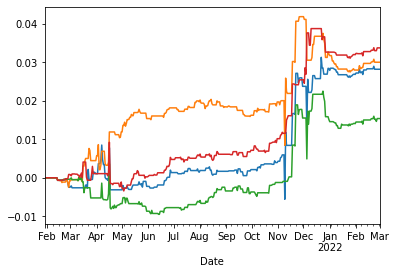

In [8]:
res = {p : pd.DataFrame for p in ok.index}


for p in ok.index:
    
    res[p] = run_strategy_1(test, p, 14, 3)
    
for r in res:

    res[r]['P&L'].cumsum().plot()

np.mean([r['P&L'].cumsum()[-2] for r in res.values()])

#run_strategy_1(test, ('BTC-USD', 'DOGE-USD'), 14, 3)

In [50]:
long = np.linspace(start=12, stop=120, num=50, dtype=int)
short = np.linspace(start=2, stop=50, num=50, dtype=int)

def run_model(lin_1, lin_2, p):
    
    train_sharpes = []
    
    length = len(lin_1)
    
    for num, l in enumerate(lin_1):
        
        load = int((num/length)*100)
        print(f'loading... {load}%')
        for s in lin_2:
            df = run_strategy_1(train, p, l, s)
            train_sharpes.append({
                'long': l,
                'short': s,
                'sharpe': get_sharpe(df['P&L'])
            })
                
    sharpes = pd.DataFrame(train_sharpes)

    sharpes['windows'] = [(l,s) for l,s in zip(sharpes['long'], sharpes['short'])]
    sharpes = sharpes.drop(columns = ['long', 'short'])

    sharpes.sort_values(by = ['sharpe'], inplace = True, ascending=False)

    sharpes.drop_duplicates(subset ="windows",
                        keep = 'first', inplace = True)

    sharpes.reset_index(inplace = True)
    sharpes = sharpes.drop(columns = ['index'])
    
    return sharpes.head().to_dict()
    

opt = {p : pd.DataFrame() for p in pairs}
    
for num, p in enumerate(pairs[:4]):
    print(f'pair number: {num+1}')
    opt[p] = run_model(long, short, p)
    

pair number: 1
loading... 0%
loading... 2%
loading... 4%
loading... 6%
loading... 8%
loading... 10%
loading... 12%
loading... 14%
loading... 16%
loading... 18%
loading... 20%
loading... 22%
loading... 24%
loading... 26%
loading... 28%
loading... 30%
loading... 32%
loading... 34%
loading... 36%
loading... 38%
loading... 40%
loading... 42%
loading... 44%
loading... 46%
loading... 48%
loading... 50%
loading... 52%
loading... 54%
loading... 56%
loading... 57%
loading... 60%
loading... 62%
loading... 64%
loading... 66%
loading... 68%
loading... 70%
loading... 72%
loading... 74%
loading... 76%
loading... 78%
loading... 80%
loading... 82%
loading... 84%
loading... 86%
loading... 88%
loading... 90%
loading... 92%
loading... 94%
loading... 96%
loading... 98%
pair number: 2
loading... 0%
loading... 2%
loading... 4%
loading... 6%
loading... 8%
loading... 10%
loading... 12%
loading... 14%
loading... 16%
loading... 18%
loading... 20%
loading... 22%
loading... 24%
loading... 26%
loading... 28%
loadi

<AxesSubplot:xlabel='Date'>

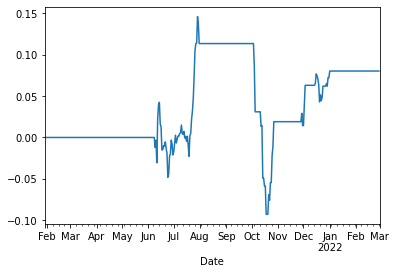

In [57]:

#for i in opt:
    
    #opt[i] = pd.DataFrame(opt[i])

#dows = [ opt[o]['windows'].to_list() for o in opt]
#opt[('BTC-USD','DOGE-USD')]['windows']


#max_sharpes = [opt[o]['sharpe'].to_list()[0] for o in opt]



In [18]:
totes = np.zeros(shape=(len(long), len(short)))
for num1, l in enumerate(long):
    for num2, s in enumerate(short):
        totes[num1, num2] = l+s


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,14.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,...,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0
1,16.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,...,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0,64.0
2,18.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,...,57.0,58.0,59.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0
3,20.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,...,59.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0
4,22.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,...,61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0
5,25.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,...,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,73.0
6,27.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,...,66.0,67.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0
7,29.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,...,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,77.0
8,31.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,...,70.0,71.0,72.0,73.0,74.0,75.0,76.0,77.0,78.0,79.0
9,33.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,...,72.0,73.0,74.0,75.0,76.0,77.0,78.0,79.0,80.0,81.0


In [63]:
iwm = yf.download('IWM', start = '2021-01-01')

iwm


train, test = train_test_split(iwm, test_size=0.5, shuffle=False)

[*********************100%***********************]  1 of 1 completed


In [74]:


def run_strategy_2(data, k, d):
    
    initial_capital = 1000
    
    #hr_lookback = 63
    
    k_period = k
    d_period = d

    df = pd.DataFrame()
    
    df['IWM'] = data['Close']
    #df[p[1]] = data['Close'][p[1]]

    df['Close'] = data['Close']
    df['High'] = data['High']
    df['Low'] = data['Low']

    #df.ta.stochrsi(k=k_period, d=d_period, append = True)
    
    n_high = df['High'].rolling(k_period).max()
    # Adds an "n_low" column with min value of previous 14 periods
    n_low = df['Low'].rolling(k_period).min()
    # Uses the min/max values to calculate the %k (as a percentage)
    df['%K'] = (df['Close'] - n_low) * 100 / (n_high - n_low)
    # Uses the %k to calculates a SMA over the past 3 values of %k
    df['%D'] = df['%K'].rolling(d_period).mean()
    
    #df['hedge_ratio'] = df[p[0]].rolling(hr_lookback).corr(df['IWM']) * df[p[0]].rolling(hr_lookback).std() / df[p[1]].rolling(hr_lookback).std()

    df['Position'] = np.nan #create a column for position 1 so we can fill it
    #df['Position 2'] = np.nan #create a column for position 2 so we can fill it
    
    stop_loss = .05
    short_val_1 = None
    long_val_1 = None
    short_val_2 = None
    long_val_2 = None
    
    for num, date in enumerate(df.index): #note: this for-loop method is easier to follow, but using np.where() gives a more efficient solution. Look up the documentation!
        
        if df.loc[date, '%K'] > 80 and df.loc[date, '%D'] > 80 and df.loc[date, '%D'] > df.loc[date, '%K']: 
            
            # -1 * (initial_capital//max(df[p[0]][:date]))
            df.loc[date, 'Position'] = -1 * (initial_capital//max(df['IWM'][:date]))
            
            #if df['Position 1'][num-1] == 0:
                #print('short_val')
                #short_val = df['Close'].iloc[num]
                #short_val_1 = df['Close'].iloc[num]
                #short_val_2 = df[p[1]].iloc[num]
            
        elif df.loc[date, '%K'] < 20 and df.loc[date, '%D'] < 20 and df.loc[date, '%D'] < df.loc[date, '%K']:
            df.loc[date, 'Position'] = 1 * (initial_capital//max(df['IWM'][:date]))
            
            #if df['Position 1'][num-1] == 0:
                #print('long_val')
                #long_val = df['Close'].iloc[num]
                #long_val_1 = df['Close'].iloc[num]
            
        elif (55 > df.loc[date, '%K'] > 45) and (55 > df.loc[date, '%D'] > 45):
            df.loc[date, 'Position'] = 0
            #short_val_1 = None
            #long_val_1 = None

        # STOP LOSS SHORT
        #elif (short_val_1) and df['Position 1'][num-1] < -1 and short_val_1 + short_val_1*stop_loss < df.loc[date, 'Close']:
            #print('short-stop')
            #df.loc[date, 'Position 1'] = 0
        
        # STOP LOSS LONG  
        #elif (long_val_1) and df['Position 1'][num-1] > 1 and long_val_1 - long_val_1*stop_loss > df.loc[date, 'Close']:
            #print('long-stop')
            #df.loc[date, 'Position 1'] = 0
        
        #else:
            
            #if (num > 0):
                #df.loc[date, 'Position 1'] = df['Position 1'][num-1]
            
            #if (num > 0) and not short_val_2 and not long_val_2:
                #df.loc[date, 'Position 2'] = df['Position 2'][num-1]  
                

   #this is the impact of the hedge ratio. Make sure you intuitively understand why this one-line solution works (the negative sign, the hedge ratio's role, the dependence on the other asset's position)
    #df['Position 2'] = -df['hedge_ratio'] * df['Position 1']
    
    df['Position'].fillna(0, inplace=True)
    #df['Position 2'].fillna(0, inplace=True)
    
    df['capital'] = initial_capital

    #df['capital'] -= (df['Position 2'].diff() * data['Close'][p[1]]).cumsum()
    df['capital'] -= (df['Position'].diff() * df['IWM']).cumsum()

    df['position_value'] = (df['Position'] * df['IWM'].shift(-1))
    df['portfolio_value'] = df['capital'] + df['position_value']
    
    df['Returns'] = (df['portfolio_value'] - initial_capital) / initial_capital
    df['P&L'] = df['Returns'].diff().fillna(0)
    
    #(df['Returns'], p[2])
    return df


<AxesSubplot:xlabel='Date'>

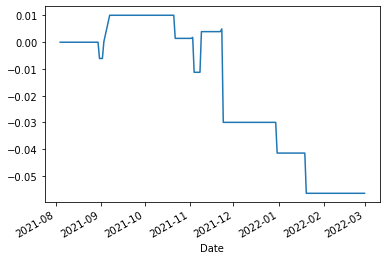

In [79]:
run_strategy_2(test, 14, 3)['Returns'].plot()